In [1]:
# ==============================
# Manufacturing Output Prediction - Capstone Project
# ==============================

# 0️⃣ Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# ------------------------------
# 1️⃣ Load Dataset
# ------------------------------
df = pd.read_csv('manufacturing_dataset.csv')
print("Dataset loaded. First 5 rows:")
display(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe().T)


Dataset loaded. First 5 rows:


,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Parts_Per_Hour
0,206.22,125.38,34.629,15.748,305.66,24.38,13.83,113.7,137.34,28
1,246.55,92.07,17.401,12.829,240.27,22.59,14.30,107.7,82.51,90
2,231.24,141.07,22.270,13.663,116.71,27.64,1.06,29.0,56.07,102
3,221.91,122.92,38.210,16.601,375.55,20.19,5.44,32.3,123.17,23
4,190.92,91.00,30.861,18.516,394.10,23.88,12.72,117.8,148.05,27



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Injection_Temperature  6000 non-null   float64
 1   Injection_Pressure     6000 non-null   float64
 2   Cycle_Time             6000 non-null   float64
 3   Cooling_Time           6000 non-null   float64
 4   Material_Viscosity     6000 non-null   float64
 5   Ambient_Temperature    6000 non-null   float64
 6   Machine_Age            6000 non-null   float64
 7   Operator_Experience    6000 non-null   float64
 8   Maintenance_Hours      6000 non-null   float64
 9   Parts_Per_Hour         6000 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 468.9 KB
None

Summary Statistics:
                        count        mean        std      min        25%  \
Injection_Temperature  6000.0  214.797257  20.267608  180.000  197.20250   
Injection_Pressure     6


Missing values per column:
Injection_Temperature    0
Injection_Pressure       0
Cycle_Time               0
Cooling_Time             0
Material_Viscosity       0
Ambient_Temperature      0
Machine_Age              0
Operator_Experience      0
Maintenance_Hours        0
Parts_Per_Hour           0
dtype: int64


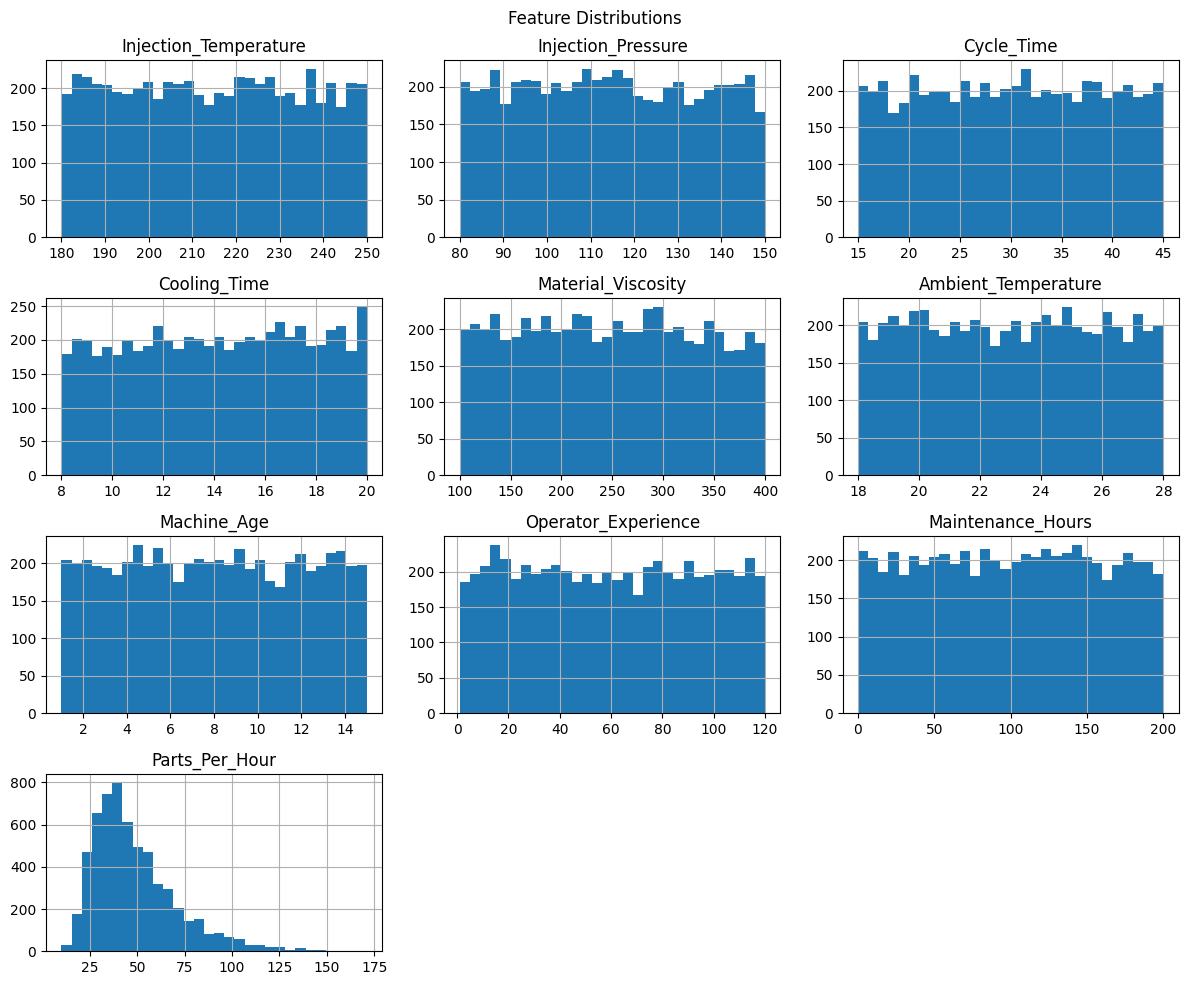

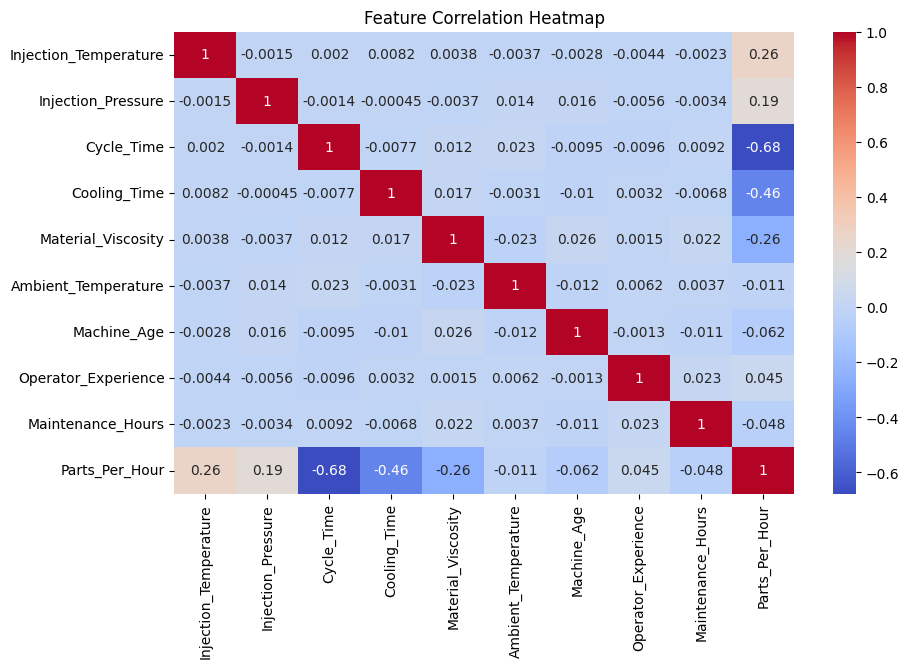

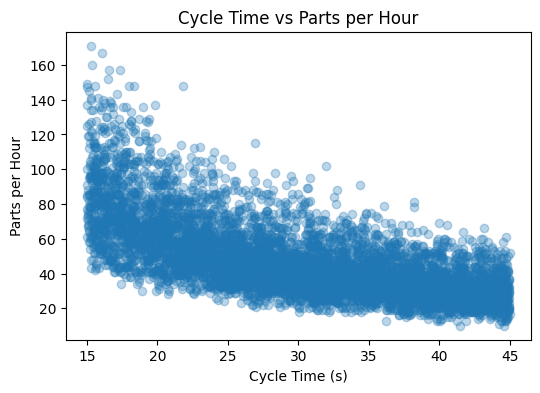

In [3]:
# ------------------------------
# 2️⃣ Quick EDA
# ------------------------------
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Histogram distributions
df.hist(bins=30, figsize=(12,10))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Scatter plot: key predictor vs target
plt.figure(figsize=(6,4))
plt.scatter(df['Cycle_Time'], df['Parts_Per_Hour'], alpha=0.3)
plt.xlabel('Cycle Time (s)')
plt.ylabel('Parts per Hour')
plt.title('Cycle Time vs Parts per Hour')
plt.show()

In [4]:
# ------------------------------
# 3️⃣ Feature Engineering
# ------------------------------
# Optional: Derived features
df['Efficiency_Ratio'] = df['Parts_Per_Hour'] / df['Cycle_Time']

In [5]:
# ------------------------------
# 4️⃣ Train/Test Split
# ------------------------------
X = df.drop(columns=['Parts_Per_Hour'])
y = df['Parts_Per_Hour']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Linear Regression (Baseline) Performance:
RMSE: 3.84
MAE: 2.99
R²: 0.97


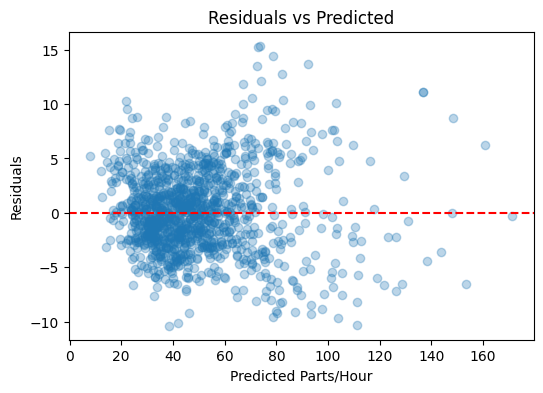

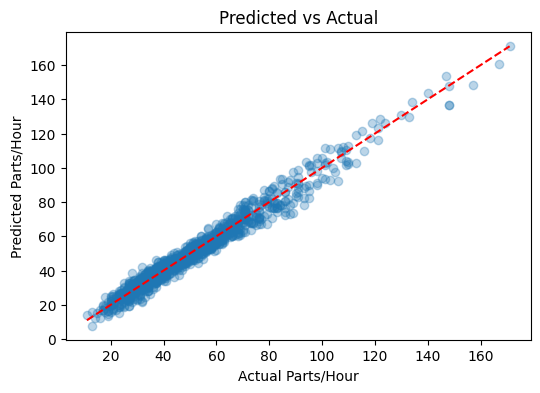

In [6]:
# ------------------------------
# 5️⃣ Baseline Model: Linear Regression with Scaling
# ------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\nLinear Regression (Baseline) Performance:")
print("RMSE:", np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print("MAE:", np.round(mean_absolute_error(y_test, y_pred),2))
print("R²:", np.round(r2_score(y_test, y_pred),3))

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Parts/Hour')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Predicted vs Actual plot
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Parts/Hour")
plt.ylabel("Predicted Parts/Hour")
plt.title("Predicted vs Actual")
plt.show()


In [7]:
# ------------------------------
# 6️⃣ Feature Importance (Linear Regression Coefficients)
# ------------------------------
scaler = pipeline.named_steps['scaler']
lr = pipeline.named_steps['lr']

coef = lr.coef_
feature_std = scaler.scale_
coef_interpretable = coef / feature_std  # scale back

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef,
    'Coef_Interpretable': coef_interpretable
}).sort_values(by='Coef_Interpretable', key=abs, ascending=False)

print("\nFeature Importance (Linear Regression):")
display(coef_df)



Feature Importance (Linear Regression):


,Feature,Coefficient,Coef_Interpretable
9,Efficiency_Ratio,16.862912,11.187429
3,Cooling_Time,-5.496104,-1.588773
6,Machine_Age,-0.854800,-0.210520
2,Cycle_Time,-1.638242,-0.189189
0,Injection_Temperature,3.154082,0.155732
1,Injection_Pressure,2.253377,0.112464
4,Material_Viscosity,-2.993678,-0.035134
7,Operator_Experience,0.547786,0.015871
8,Maintenance_Hours,-0.425507,-0.007384
5,Ambient_Temperature,-0.002608,-0.000905


In [8]:
# ------------------------------
# 7️⃣ Cross-Validation (K-Fold)
# ------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=kf)
cv_rmse = np.sqrt(-cv_scores)
print("\n5-Fold CV RMSE (per fold):", np.round(cv_rmse,2))
print("CV RMSE mean:", np.round(cv_rmse.mean(),2))



5-Fold CV RMSE (per fold): [3.84 3.77 3.67 3.76 3.73]
CV RMSE mean: 3.76


In [9]:
# ------------------------------
# 8️⃣ Regularization: Ridge & Lasso with GridSearch
# ------------------------------

# Ridge
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
param_grid_ridge = {'ridge__alpha': [0.01, 0.1, 1, 10, 50, 100]}
gs_ridge = GridSearchCV(pipe_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_ridge.fit(X_train, y_train)
best_ridge = gs_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

print("\nRidge Regression:")
print("Best alpha:", gs_ridge.best_params_)
print("RMSE:", np.round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)),2))
print("R²:", np.round(r2_score(y_test, y_pred_ridge),3))

# Lasso
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=5000))])
param_grid_lasso = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
gs_lasso = GridSearchCV(pipe_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_lasso.fit(X_train, y_train)
best_lasso = gs_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

print("\nLasso Regression:")
print("Best alpha:", gs_lasso.best_params_)
print("RMSE:", np.round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)),2))
print("R²:", np.round(r2_score(y_test, y_pred_lasso),3))

# Feature importance from Ridge
coef_ridge = best_ridge.named_steps['ridge'].coef_
coef_df_ridge = pd.DataFrame({'Feature': X.columns, 'Ridge_Coefficient': coef_ridge}).sort_values(by='Ridge_Coefficient', key=abs, ascending=False)
print("\nRidge Feature Importance:")
display(coef_df_ridge)



Ridge Regression:
Best alpha: {'ridge__alpha': 0.1}
RMSE: 3.84
R²: 0.97

Lasso Regression:
Best alpha: {'lasso__alpha': 0.01}
RMSE: 3.85
R²: 0.97

Ridge Feature Importance:


,Feature,Ridge_Coefficient
9,Efficiency_Ratio,16.861692
3,Cooling_Time,-5.496331
0,Injection_Temperature,3.154212
4,Material_Viscosity,-2.993781
1,Injection_Pressure,2.253471
2,Cycle_Time,-1.639183
6,Machine_Age,-0.854822
7,Operator_Experience,0.547802
8,Maintenance_Hours,-0.425529
5,Ambient_Temperature,-0.002613


In [10]:
# ------------------------------
# 9️⃣ Save Model for Deployment
# ------------------------------
import joblib
from datetime import datetime
import json
import os

# ✅ Create a folder to store artifacts
os.makedirs("model_artifacts", exist_ok=True)

# ✅ Extract model and scaler from best pipeline
model = best_ridge.named_steps['ridge']
scaler = best_ridge.named_steps['scaler']

# ✅ Save them safely using joblib
joblib.dump(model, "model_artifacts/ridge_model.pkl")
joblib.dump(scaler, "model_artifacts/scaler.pkl")

# ✅ Save metadata for reference
metadata = {
    "model_name": "Ridge Regression",
    "best_params": gs_ridge.best_params_,
    "rmse": float(np.round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 3)),
    "r2": float(np.round(r2_score(y_test, y_pred_ridge), 3)),
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open("model_artifacts/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Model, scaler, and metadata saved successfully in 'model_artifacts/' folder.")


✅ Model, scaler, and metadata saved successfully in 'model_artifacts/' folder.


In [11]:
# ------------------------------
# 🔟 Model Loading Functions (Verification)
# ------------------------------

def load_model(model_path='ridge_model.pkl', scaler_path='scaler.pkl', metadata_path='model_metadata.json'):
    """Load the trained model, scaler, and metadata."""
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return model, scaler, metadata

# Test loading
model_loaded, scaler_loaded, metadata_loaded = load_model()
print("✅ Model and Scaler loaded successfully!")
print("📊 Metadata:", metadata_loaded)

✅ Model and Scaler loaded successfully!
📊 Metadata: {'model_name': 'Ridge Regression', 'best_params': {'ridge__alpha': 0.1}, 'rmse': 3.844, 'r2': 0.97, 'created_at': '2025-10-28 12:33:57'}
